# Combining and Filtering Data Tables in `pandas` 

## In this section

- Using the `merge` and `join` methods to combine pandas `DataFrames`
- Filtering missing data out of pandas `DataFrames`

## Prerequisites

- Running python
- Basic variable assignment and calling functions in python
- Loading pandas `DataFrames`

## Table of Content

* [Bioinformatic analysis often involves combining data from multiple sources](#Bioinformatic-analysis-often-involves-combining-data-from-multiple-sources)
* [Merging and Joining `pandas` `DataFrames`](#Merging-Tables-in-Pandas)
* [Handling Missing Data](#Handling-Missing-Data)
   
   -[Method 1: the `dropna` method](#Method-1---use-the-built-in-dropna-method)
   
   -[Method 2: identify and filter out `NaN` rows](#Method-2---identify-and-remove-rows-with-NaN-values-using-row-filtering-and-logic-operations)
* [A Biological Example: Combining Coral Datasets](#A-Biological-Example---Combining-Coral-Datasets)
   
* [Exercises](#Exercises)

## Bioinformatic analysis often involves combining data from multiple sources

In most interesting bioinformatic analyses, the data we want to compare doesn't all start in one place. For example, if we were studying how aging affects the microbiome, perhaps we have one table that tells us how old each patient is, and another that contains a summary of microbiome diversity data for each patient. 

If there are hundreds or thousands of patients, the order of patients differs between datasets, or if some data are missing (one patient didn't want to give her age, one microbiome amplicon library failed to sequence), it can be very obnoxious to match up these datasets by hand. Worse, it would be easy to make a mistake that might influence your results.

Luckily, `pandas` `DataFrame` objects provide good methods for combining data. Additionally, they include useful tools for filtering your dataset to remove missing data. Both these activities often end up being important parts of larger bioinformatics projects, so it's worth devoting some time to practicing them.

# Merging Tables in Pandas

Let's walk through combining data from two tables, using a simple example. In this example, we have one file, `gene_id_vs_length.txt` that says the length of many genes in a genome. (**Side note:**. You could make such a file yourself by using a FASTA parser to parse a genome file, a function you wrote to calculate the length of each gene, and then writing out the results into a `.tsv` file by separating out each gene id from each length with a tab or '\t' character).

You have a second file `gene_id_vs_hgt.txt` that says whether there is evidence that each gene underwent horizontal gene transfer (HGT) - a process in which unrelated species can exchange genetic material "horizontally" across the branches of the tree of life. (**Side note**: this process is super important for understanding the spread of antibiotic resistance genes, as these are commonly horizontally transferred between bacterial species).

We want to compare whether horizontally transferred genes tend to be shorter, longer, or the same length as non-horizontally transferred genes. Therefore, we need to combine the information in our two tables into a single `pandas` `DataFrame`.

## Download some example data

First, let's download our data. In a real research project, you could either use code like that below to download data from an ftp site, or download it by hand and put it into the same folder that you ran your jupyter notebook from.

In [5]:
#Import the urlretrieve function
from urllib.request import urlretrieve

#Save the looooong web address (url) of our data in a python string 
chapter_url = 'https://raw.githubusercontent.com/zaneveld/full_spectrum_bioinformatics/master/content/07_tabular_omics_data/resources/'
#Set the name of the file where we want to save the data
file_names = ['gene_id_vs_length.txt','gene_id_vs_hgt.txt']

#Download the data 
for file_name in file_names:
    print(f"Downloading {file_name}")
    urlretrieve(chapter_url+file_name, file_name)

## Check that we have the data files

In [8]:
from os import listdir
listdir('./')


['scenario_1_otus_pandas.tsv',
 'rarefaction_5000.png',
 'gene_id_vs_length.txt',
 'rarefaction_10000.png',
 '.DS_Store',
 'merging_tables.ipynb',
 'analyzing_tabular_omics_data_in_pandas.ipynb',
 'resources',
 'rarefaction_1000.png',
 'scenario_1_otus_pandas.txt',
 'simulating_microbiome_sampling_depth.ipynb',
 'tabular_omics_data.ipynb',
 '.ipynb_checkpoints',
 'rarefaction_50.png',
 'gene_id_vs_hgt.txt',
 'rarefaction_500.png']

Check the files listed, and just make sure that 'gene_id_vs_length.txt', and 'gene_id_vs_hgt.txt' are in the list.

## Load each table into a `pandas` `DataFrame`.

Next, we'll import pandas and load each of our data tables into a pandas dataframe.

In [10]:
import pandas as pd

gene_length_df = pd.read_csv('./gene_id_vs_length.txt',sep = '\t')
gene_length_df = gene_length_df.set_index('gene_id')

gene_length_df

,gene_length
gene_id,
gene1,1200
gene2,500
gene3,750
gene4,2000
gene5,3500
gene6,800
gene7,900
gene8,3000
gene9,3200


In [11]:
gene_hgt_df = pd.read_csv('./gene_id_vs_hgt.txt',sep = '\t')
gene_hgt_df = gene_hgt_df.set_index('gene_id')

gene_hgt_df

,horizontally_transferred
gene_id,
gene1,0
gene2,1
gene3,1
gene4,0
gene5,0
gene6,1
gene7,1
gene8,0
gene9,0


## Types of Joins 

There are several methods for joining tables together using Pandas DataFrames. Join methods differ in how they handle missing data. For example, if a gene is in your first table but not your second one, should it be included or excluded from the joined table? 

This type of problem comes up all the time in databases (essentially large collections of tables, linked together by shared ids). Therefore, folks who work with database languages like `SQL` have developed some vocabulary for describing different types of joins. It's worth learning the basics even if you don't use databases, because the same language is used in many other settings, including in `pandas`.

Here are the most common ways of joining two tables together:

**inner join** -- an inner join is the most strict type of joining or merging tables. It only joins rows that   that match for BOTH tables, and excludes all others.

**outer join** -- an outer join is the least strict, most loosy-goosy join. An outer join take all rows that appear in *either* table, leave empty entries if data is missing

**left join** -- data in the rightmost table is included only if it matches an id in the left table, otherwise it is excluded.

**right join** -- data in the leftmost table is included only if it matches an id in the left table, otherwise it is excluded.

## Combining tables with `join`
We will use an 'outer' join to put together our two tables. Sensibly enough, there is a DataFrame method called `join` that will join your DataFrame to another.

In [13]:
combined_df = gene_length_df.join(gene_hgt_df, how = 'outer')

combined_df

,gene_length,horizontally_transferred
gene_id,,
gene1,1200,0
gene2,500,1
gene3,750,1
gene4,2000,0
gene5,3500,0
gene6,800,1
gene7,900,1
gene8,3000,0
gene9,3200,0


## Handling Missing Data

It is common to have missing data in Bioinformatics dataset. Even if each of your data sources is 100% complete, they may cover different sets of species, resulting in missing data when you combine them. For example, you might have physiological but not genomic data for one organism, and genomic but not physiological data for another.
Unfortunately, organisms lacking either type of data would normally have to be removed from your analysis.

Inside `pandas`, missing data is shown as `NaN`, short for 'not a number'. So when we have missing data, we often have to do some work to filter out any rows of our `pandas` `DataFrame` that have `NaN` values.

To explore this, let's artificially add missing data (and therefore `NaN` values) to our dataframe. You would never do this in practice, of course, but it will provide us a simple example to work with, where we know exactly which data we want to exclude.

### Artificially introduce 2 missing data points to our table, as an example

We will use the `DataFrame` `.loc` property to set the value of gene length to `None` for gene10, and the value of horizontally_transferred to `None` for gene7. Recall that the `.loc` property lets you specify entries in the `DataFrame` based on the name of the row, then the column, both of which we right inside square brackets (similar to indexing into a list or retrieving a key from a dict). 

In [201]:
#Artificially introduce some missing data

combined_df.loc['gene10','gene_length'] = None
combined_df.loc['gene7','horizontally_transferred'] = None

### Examine our dataframe to confirm that some data are now missing

Next let's take a look at our dataframe so we can see what this missing data looks like.

In [202]:
combined_df

,gene_length,horizontally_transferred
gene_id,,
gene1,1200.0,0.0
gene2,500.0,1.0
gene3,750.0,1.0
gene4,2000.0,0.0
gene5,3500.0,0.0
gene6,800.0,1.0
gene7,900.0,NaN
gene8,3000.0,0.0
gene9,3200.0,0.0


As expected we nbow see 'NaN' written in the two places where we have missing data.

## Method 1 - use the built-in dropna method

The first way we can filter out rows that have missing data is to use the built in `.dropna()` method of `pandas` `DataFrames`. This will filter out *all* rows that have *any* missing data in *any* column, and return the resulting DataFrame to us. 

For simple cases like this one, `.dropna()` is perfect. Here's how it works:

In [204]:
filtered_df = combined_df.dropna()
filtered_df

,gene_length,horizontally_transferred
gene_id,,
gene1,1200.0,0.0
gene2,500.0,1.0
gene3,750.0,1.0
gene4,2000.0,0.0
gene5,3500.0,0.0
gene6,800.0,1.0
gene8,3000.0,0.0
gene9,3200.0,0.0
gene11,5300.0,0.0


Great! The `.dropna()` method has removed rows with missing data, so gene 10 and gene 7 are now excuded from our table.

## Method 2 - identify and remove rows with `NaN` values using row filtering and logic operations

For most practical uses, `.dropna` works great. But sometimes we want more control over what gets dropped. Or perhaps we want to save all the rows with problems so we can look at them by hand - usally a very important step to make sure everything we're removing is justified.

Implementing a similar process by hand is also a very useful way to understand how `pandas` `DataFrame` objects work, since we will break up a complex process into smaller steps, each of which can be examined one by one.

### Building a DataFrame of Boolean values showing which table entries have `NaN` values 

First, we'll use the `isnull()` function to build a table with `True` every place that the data table has an `NaN`, and `False` everywhere else.

*If our method works, we expect `False` everywhere except the gene length entry for `gene10` and the `horizontally_transferred` column for `gene7`.


In [205]:
bad_values = pd.isnull(combined_df)
print(bad_values)

         gene_length  horizontally_transferred
gene_id                                       
gene1          False                     False
gene2          False                     False
gene3          False                     False
gene4          False                     False
gene5          False                     False
gene6          False                     False
gene7          False                      True
gene8          False                     False
gene9          False                     False
gene10          True                     False
gene11         False                     False
gene12         False                     False


## Find bad rows from table of null values

Second, we want to figure out which rows are no good using our giant table of all the individual entries in our table that are `NaN`. 

We now have a whole dataframe filled with True or False, based on which entries are `NaN`. However, to be able to select or filter rows, we need a single column of True or False values. Depending on the application, we might throw out rows that have any `NaN` values (i.e. `NaN` in at least one column), or only those that have all `NaN` values (`NaN` in every column).

In pandas there are DataFrame methods that can automate the process of finding rows where `any` or `all` columns meet some criterion. These methods can then be applied to a DataFrame full of `True` or `False` values to find our bad rows.

These methods work for both rows or columns, so we need to specify `axis = 1` (columns) to get the result we expect. The alternative setting (`axis = 0`, the default value) would be more useful if we were getting rid of *columns* that had an `NaN` in any row.

**If our method works, we expect `False` for all genes except `gene7` and `gene10` where we added `NaN` values**

In [206]:
bad_rows = bad_values.any(axis=1)
print(bad_rows)

gene_id
gene1     False
gene2     False
gene3     False
gene4     False
gene5     False
gene6     False
gene7      True
gene8     False
gene9     False
gene10     True
gene11    False
gene12    False
dtype: bool


### Filter the table to include all the rows except the bad ones

Our series of True and False values can now be used to select rows from our original data table using regular row indexing.

One big help here will be the `~` (tilda) character, which inverts `True` and `False` in selections in pandas. This will let us select all the good rows based on their having `False` values in the bad_rows Series.

In [207]:
filtered_df = combined_df[~bad_rows]
print(filtered_df)

         gene_length  horizontally_transferred
gene_id                                       
gene1         1200.0                       0.0
gene2          500.0                       1.0
gene3          750.0                       1.0
gene4         2000.0                       0.0
gene5         3500.0                       0.0
gene6          800.0                       1.0
gene8         3000.0                       0.0
gene9         3200.0                       0.0
gene11        5300.0                       0.0
gene12        4000.0                       0.0


### Retain bad rows for later inspection.

It's a good idea to keep a copy of the bad rows so you can figure out what went wrong. We can do this by repeating our command without inverting the selection with `~`.

In [208]:
bad_rows_df = combined_df[bad_rows]
print(bad_rows_df)

         gene_length  horizontally_transferred
gene_id                                       
gene7          900.0                       NaN
gene10           NaN                       1.0


# A Biological Example - Combining Coral Datasets

Let's practice what we've learned about joining and filtering `pandas` `DataFrames` to join together three tables with information on corals.

We want to put together a table that will help us figure out if the microbes that live on corals are correlated with how often they get disease. We have three tables, that each hold different important pieces of information about disease or microbial symbiosis in several different kinds of corals. Each of these tables is a `.tsv` file, meaning that `\t` characters separate the columns of each dataframe.

`coral_disease_susceptibility.txt` - this file says the average prevalence of disease in diver surverys of each type of coral. 

`coral_microbiome diversity.txt` - this file says how diverse each coral's microbiome is on average, based on 16S rRNA gene amplicon sequencing.

`coral_symbiont_abundance.txt` - this file says how common a particular bacterium, *Endozoicomonas* was in 16S rRNA gene amplicon sequencing from that species.

The common identifier that will let us link together the tables will be the genus name of corals (*Acropora*), *Porites*, etc). Let's first check that we have all the tables we need in our current folder, and then move on to loading the three dataframes.

## Download coral data

In [16]:
#Import the urlretrieve function
from urllib.request import urlretrieve

#Save the looooong web address (url) of our data in a python string 
chapter_url = 'https://raw.githubusercontent.com/zaneveld/full_spectrum_bioinformatics/master/content/07_tabular_omics_data/resources/'
#Set the name of the file where we want to save the data
file_names = ['coral_disease_susceptibility.txt', 'coral_microbiome_diversity.txt', 'coral_symbiont_abundance.txt']

#Download the data 
for file_name in file_names:
    print(f"Downloading {file_name}")
    urlretrieve(chapter_url+file_name, file_name)

## Load all three DataFrames

In [18]:
micro_div_df = pd.read_csv('coral_microbiome_diversity.txt',sep="\t")
endo_df = pd.read_csv('coral_symbiont_abundance.txt',sep='\t')
disease_df = pd.read_csv('coral_disease_susceptibility.txt',sep='\t')

## Set the host genus column to be the index

In [19]:
micro_div_df = micro_div_df.set_index("host_genus")
endo_df = endo_df.set_index("host_genus")
disease_df = disease_df.set_index("host_genus")

## `join` tables using their indices

When using the `join` method, we can only combine two tables at a time. So we'll have to pick any two of our tables to stick together to make a combined DataFrame, and then use a second `join` command to add the third table to that combined dataframe.

In [21]:
#First make a combined DataFrame by joining the disease and Endozoicomonas DataFrames
combined_df = endo_df.join(disease_df,how='outer')

#Now add in the microbial diversity data with another join statement
combined_df = combined_df.join(micro_div_df,how='outer')

#Look at our combined DataFrame
combined_df

,average_endozoicomonas_per_1000_reads,disease_susceptibility,faith_pd_tissue
host_genus,,,
Acanthastrea,8.000000,0.000000,62.672799
Acropora,58.681818,3.643113,22.585867
Aiptasia,NaN,NaN,132.477305
Alveopora,441.333333,0.749064,98.928105
Astrea,302.666667,NaN,19.777494
...,...,...,...
Stylophora,634.428571,3.687151,28.399778
Tubastraea,7.285714,0.909091,104.221069
Tubipora,NaN,NaN,NaN


## Drop rows with missing data

As you may have noticed in the combined table, there are a lot of `NaN` values! We probably want to exclude missing data from our analysis.

In [23]:
combined_df = combined_df.dropna()

**Stop and check**: did this command remove all the `NaN` values from your table?

## Save our combined data to a file

It's a good idea to save your final, processed dataset to a file. This helps ensure that anything you notice in a graph can be easily found in your data. If you publish your analysis in a scientific journal, the raw data for each figure should be made available (e.g. at many journals it can be put into an Excel spreadsheet and uploaded as a "Supplementary Data" file). 

In the past, I have had to use image analysis software to literally click on the points of a scatterplot to get the raw data values because they were not made available by the authors - and perhaps surprisingly this is not an uncommon occurence! We never want to put our readers through that, so uploading raw data is the way to go. 

We can use the pandas `.to_csv` method to save out combined DataFrame as a data file. If we want a tab-separated values or '.tsv' file, we'll set 'sep' to '\t' (just like when we loaded the file), and make sure the filename ends in '.txt' or '.tsv'. If we want a comma separated values (.csv) file, we'll set sep = ',' and make sure the filename ends in '.csv'

In [25]:
combined_df.to_csv("combined_coral_data.tsv",sep="\t")

## Make a scatterplot

Finally, we can extract any columns we want into python lists, and use them for other analyses like making scatterplots or other graphs.

Text(0, 0.5, 'Disease Susceptibility')

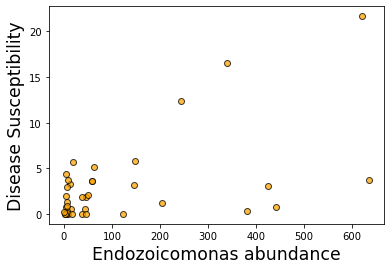

In [26]:
from matplotlib.pyplot import scatter,xlabel,ylabel

#Extract data series from the DataFrame
endo_data = combined_df['average_endozoicomonas_per_1000_reads']
disease_data = combined_df['disease_susceptibility']

#Convert to lists
endo_data = list(endo_data)
disease_data = list(disease_data)

#Make a scatterplot
scatter(endo_data,disease_data,facecolor='orange',edgecolor='black',alpha = 0.75)
xlabel("Endozoicomonas abundance", size = 'xx-large')
ylabel("Disease Susceptibility", size = 'xx-large')

**Important Note about Statistical Independence and Comparing the Traits of Species**: This trend looks interesting, but to test for significance in this trend we would **have** to use some type of phylogenetic comparative method. This is because all 'regular' statistical methods assume data are statistically independent of each other. However, species evolve on a tree, and have traits that are correlated (NOT independent) of their relatives. This sounds like a minor issue, but actually results in **massive** false positive rates anytime you compare the traits of species without accounting for the structure of the tree. So we should treat our scatterplot as a first insight, but use something like phylogenetic independent contrasts (PIC) or phylogenetic generalized least squares (PGLS) if we wanted to test for significance.

## Exercises

- **Exercise 1**. Using the code below, make two dataframes with missing data. Then try to join them using an outer, inner, left or right join. Describe what happens in each case, paying attention to which data points are included, and which are excluded.

In [212]:
import pandas as pd

#Make and examine our first set of data for individuals 1-4
df1_data = {"individual_id":[1,2,3,4],"length":[10,None,5,7],"n_offspring":[None,1,3,5]}

#Make a dataframe directly from our dictionary
#NOTE: normally in real applciations we'd load our dataframe using pd.read_csv to load a file
df1 = pd.DataFrame(df1_data)

df1 = df1.set_index('individual_id')
df1

,length,n_offspring
individual_id,,
1,10.0,NaN
2,NaN,1.0
3,5.0,3.0
4,7.0,5.0


In [216]:
#Now let's say we have additional data for individuals 2-6
df2_data = {"individual_id":[2,3,4,5,6], "main_diet":["frogs","newts","frogs","insects",None]}

df2 = pd.DataFrame(df2_data)
df2 = df2.set_index('individual_id')
df2

,main_diet
individual_id,
2,frogs
3,newts
4,frogs
5,insects
6,None


As a reminder, here's an example of how to join these tables:

In [220]:
combined_df = df1.join(df2,how="outer")
combined_df

,length,n_offspring,main_diet
individual_id,,,
1,10.0,NaN,NaN
2,NaN,1.0,frogs
3,5.0,3.0,newts
4,7.0,5.0,frogs
5,NaN,NaN,insects
6,NaN,NaN,None


Now try changing the 'outer' in `how = 'outer'` to one of the other join methods discussed in this chapter. How do es that change the results?

- **Exercise 2**. Join together the data from **Exercise 1** using an 'outer' join. Next, filter that table to drop any rows with `NaN` values, using either method described earlier in the chapter.

- **Exercise 3**. Imagine that you wanted to compare the `main_diet` and `n_offspring` columns to see if diet affected the number of offspring your organisms had.  

## Reading Responses & Feedback 

^Make this a hyperlink using Google Forms

## Further Reading
 - [Selecting Subsets of Data in Pandas Part 1](https://www.dunderdata.com/blog/selecting-subsets-of-data-in-pandas-part-1)
 - [Selecting Subsets of Data in Pandas Part 2](https://www.dunderdata.com/blog/selecting-subsets-of-data-in-pandas-part-2)